In [2]:
# Essential libraries for classification and logistic regression
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

# SciPy provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations,
# differential equations, statistics and many other classes of problems.
# https://scipy.org/
#
from scipy import stats ### << key addition

All required libraries imported successfully!


In [3]:
# Download financial data for classification experiments
# We'll use multiple stocks to create a comprehensive dataset

tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'META', 'AMZN', 'NVDA', 'JPM']
stock_data = {}

for ticker in tickers:
    print(f"...loading {ticker}")
    stock_data[ticker] = yf.Ticker(ticker).history(start=datetime.now() - timedelta(days=365 * 10),end=datetime.now())

print(f"\nSuccessfully loaded data for {len(stock_data)} stocks")
print(f"Date range: {stock_data['AAPL'].index[0].date()} to {stock_data['AAPL'].index[-1].date()}")
print(f"Total trading days: {len(stock_data['AAPL'])} per stock")

...loading AAPL
...loading GOOGL
...loading MSFT
...loading TSLA
...loading META
...loading AMZN
...loading NVDA
...loading JPM

Successfully loaded data for 8 stocks
Date range: 2023-10-23 to 2025-10-21
Total trading days: 501 per stock


In [49]:
def calculate_rsi_wilder(close: pd.Series, window: int = 14) -> pd.Series:
    """
    Wilder's RSI implementation (smoothed average gains/losses).
    We will shift(1) later so feature at date D uses info up to D-1.

    https://www.oanda.com/us-en/trade-tap-blog/trading-knowledge/understanding-the-relative-strength-index/
    """
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()
    rs = avg_gain / (avg_loss.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi

def rolling_zscore(series: pd.Series, window: int = 20) -> pd.Series:
    """Rolling z-score over a trailing window."""
    roll_mean = series.rolling(window).mean()
    roll_std = series.rolling(window).std(ddof=0)
    return (series - roll_mean) / roll_std

def pct_change_safe(series: pd.Series, periods: int = 1) -> pd.Series:
    """Percent change with inf/NaN protection."""
    s = series.pct_change(periods)
    return s.replace([np.inf, -np.inf], np.nan)

# ---------- Core feature builder for ONE ticker (date-aware) ----------

def create_features_one_ticker(df: pd.DataFrame,
                               ticker_name: str,
                               rsi_window: int = 14,
                               fast_ma: int = 5,
                               slow_ma: int = 20,
                               vol_window: int = 20,
                               vol_ma_window: int = 5) -> pd.DataFrame:
    """
    Build predictive features that only use information available up to t-1.
    Returns a DataFrame indexed by date with feature columns + 'Ticker' + 'AsOfDate'.

    IMPORTANT:
    - The .shift(1) at the end means the row dated D represents features "as of" D,
      computed using data through D-1. We make that explicit via AsOfDate == index.
    """
    # Ensure datetime index is named & sorted for clarity
    df = df.copy()
    df = df.sort_index()
    df.index.name = 'Date'

    out = pd.DataFrame(index=df.index.copy())

    # Basic price & volume
    close = df['Close']
    volume = df['Volume']

    # 1) Returns & momentum (past info only)
    out['ret_1d']  = pct_change_safe(close, 1)
    out['ret_5d']  = pct_change_safe(close, 5)
    out['ret_10d'] = pct_change_safe(close, 10)

    # 2) Moving averages & spreads
    ma_fast = close.rolling(fast_ma).mean()
    ma_slow = close.rolling(slow_ma).mean()
    out['ma_fast'] = ma_fast
    out['ma_slow'] = ma_slow
    out['ma_spread'] = ma_fast - ma_slow
    out['price_minus_ma_fast'] = close - ma_fast
    out['price_minus_ma_slow'] = close - ma_slow

    # 3) Volatility (rolling std of daily returns)
    daily_ret = pct_change_safe(close, 1)
    out['volatility_20d'] = daily_ret.rolling(vol_window).std(ddof=0)

    # 4) RSI (Wilder) and its z-score
    rsi = calculate_rsi_wilder(close, rsi_window)
    out['rsi'] = rsi
    out['rsi_z_20d'] = rolling_zscore(rsi, 20)

    # 5) Volume features
    vol_ma = volume.rolling(vol_ma_window).mean()
    out['vol_ma_5'] = vol_ma
    out['vol_rel'] = volume / vol_ma
    out['vol_above_ma'] = (volume > vol_ma).astype(int)

    # 6) Binary flags relative to MAs (price regime)
    out['price_above_ma_fast'] = (close > ma_fast).astype(int)
    out['price_above_ma_slow'] = (close > ma_slow).astype(int)

    # --- CRITICAL: Prevent look-ahead leakage ---
    # Shift ALL features by 1 so that the feature row at date D uses info up to D-1.
    out = out.shift(1)

    # Label when these features are *known*: AsOfDate == index (Date)
    out['AsOfDate'] = out.index

    # Keep identifier
    out['Ticker'] = ticker_name

    # Drop rows that are now NaN because of rolling/shift
    out = out.dropna()

    return out

# ---------- Build features for ALL tickers and combine ----------

def build_feature_matrix(stock_data: dict) -> pd.DataFrame:
    """
    stock_data: dict[ticker -> DataFrame with at least Close, Volume columns]
    Returns a combined feature matrix across all tickers (Date index).
    """
    frames = []
    for ticker, df in stock_data.items():
        if not {'Close', 'Volume'}.issubset(df.columns):
            print(f"Skipping {ticker}: required columns missing.")
            continue
        feats = create_features_one_ticker(df, ticker_name=ticker)
        frames.append(feats)

    if not frames:
        raise ValueError("No valid tickers to process.")
    X = pd.concat(frames, axis=0).sort_index()
    X.index.name = 'Date'
    return X

# ---------- (Optional) Friendly feature dictionary to print at the end ----------

FEATURE_DICTIONARY = {
    'ret_1d'               : '1-day % return of Close',
    'ret_5d'               : '5-day % return of Close',
    'ret_10d'              : '10-day % return of Close',
    'ma_fast'              : '5-day moving average of Close',
    'ma_slow'              : '20-day moving average of Close',
    'ma_spread'            : 'Difference: MA(5) - MA(20)',
    'price_minus_ma_fast'  : 'Close - MA(5)',
    'price_minus_ma_slow'  : 'Close - MA(20)',
    'volatility_20d'       : 'Rolling 20-day std of daily returns',
    'rsi'                  : 'RSI(14) using Wilder’s smoothing',
    'rsi_z_20d'            : 'Z-score of RSI over trailing 20 days',
    'vol_ma_5'             : '5-day moving average of Volume',
    'vol_rel'              : 'Relative Volume = Volume / MA(5)',
    'vol_above_ma'         : '1 if Volume > MA(5) (yesterday), else 0',
    'price_above_ma_fast'  : '1 if Close > MA(5) (yesterday), else 0',
    'price_above_ma_slow'  : '1 if Close > MA(20) (yesterday), else 0',
    'AsOfDate'             : 'Date the features are considered known/usable',
    'Ticker'               : 'Security symbol'
}

def print_feature_dictionary(columns):
    print("\n=== Feature Dictionary (what each column means) ===")
    for c in columns:
        desc = FEATURE_DICTIONARY.get(c, "(no description available)")
        print(f"- {c}: {desc}")

# ---------- Build Feature Matrix ----------

X_features = build_feature_matrix(stock_data)

def create_binary_target_one_ticker(df: pd.DataFrame, ticker_name: str) -> pd.DataFrame:
    """
    Create a binary target for one ticker:
      Target = 1 if next day's Close > today's Close, else 0.
    Drops the last row (no next-day price).
    Returns DataFrame indexed by Date with columns ['Target', 'Ticker'].
    """
    df = df.copy().sort_index()
    df.index.name = 'Date'

    next_close = df['Close'].shift(-1)
    target = (next_close > df['Close']).astype('Int64')  # Int64 tolerates NaN before drop

    out = pd.DataFrame(index=df.index.copy())
    out['Target'] = target
    out['Ticker'] = ticker_name

    # Remove last row where next day's price is missing
    out = out.dropna(subset=['Target'])
    # Cast to int now that NaNs are gone
    out['Target'] = out['Target'].astype(int)
    return out

def build_target_matrix(stock_data: dict) -> pd.DataFrame:
    """
    Build the binary target for all tickers in stock_data.
    Returns a Date-indexed DataFrame with ['Target', 'Ticker'].
    """
    frames = []
    for ticker, df in stock_data.items():
        if 'Close' not in df.columns:
            print(f"Skipping {ticker}: 'Close' column missing.")
            continue
        y = create_binary_target_one_ticker(df, ticker_name=ticker)
        frames.append(y)

    if not frames:
        raise ValueError("No valid tickers to process for targets.")
    y_all = pd.concat(frames, axis=0).sort_index()
    y_all.index.name = 'Date'
    return y_all

# --- Build y_target (make sure stock_data exists from your download step) ---
y_target = build_target_matrix(stock_data)

# --- Merge features (from Step A) with target (Step B) ---
# Assumes X_features already exists from Step A and includes ['Ticker', 'AsOfDate'] with Date index.
dataset = (X_features.reset_index().merge(y_target.reset_index(),on=['Date', 'Ticker'],how='inner').set_index('Date').sort_index())

# Optional: keep columns ordered nicely
cols_front = ['Ticker', 'AsOfDate', 'Target']
other_cols = [c for c in dataset.columns if c not in cols_front]
dataset = dataset[cols_front + other_cols]

print("Merged dataset shape (features + target):", dataset.shape)
print("\nSample rows (note: features are 'as of' Date; Target labels tomorrow's move):")
print(dataset.head(8)[['Ticker', 'AsOfDate', 'Target']])

# --- Quick sanity checks & class balance ---

# 1) No future leakage in merge (AsOfDate should equal the row Date)
same_dates = (dataset.index.normalize() == pd.to_datetime(dataset['AsOfDate']).dt.normalize())
if not bool(same_dates.all()):
    raise AssertionError("AsOfDate does not match Date for some rows. Check shifting/merge steps.")

# 2) Class balance overall
print("\nTarget distribution (overall):")
print(dataset['Target'].value_counts(normalize=True).rename({0: 'Down/NotUp', 1: 'Up'}).round(3))

# 3) Class balance by ticker (handy for students)
print("\nTarget distribution by Ticker (first few):")
by_ticker = (dataset.groupby('Ticker')['Target'].value_counts(normalize=True).rename('ratio').reset_index()
             .pivot(index='Ticker', columns='Target', values='ratio').rename(columns={0: 'Down/NotUp', 1: 'Up'}).round(3))

# 4) Show a tiny timeline snippet for one ticker to reinforce timing
one = dataset[dataset['Ticker'] == 'AAPL'].head(6)
print("\nAAPL timeline peek (Date, AsOfDate, Target):")
print(one[['Ticker', 'AsOfDate', 'Target']])

# Merge features and target on both Date and Ticker
dataset = (
    X_features
    .reset_index()                  # bring 'Date' out of index
    .merge(y_target.reset_index(),  # align by Date + Ticker
           on=['Date', 'Ticker'],
           how='inner')
    .set_index('Date')
    .sort_index()
)

dataset = dataset.reset_index()
dataset.head(5)

Merged dataset shape (features + target): (4311, 19)

Sample rows (note: features are 'as of' Date; Target labels tomorrow's move):
                          Ticker                  AsOfDate  Target
Date                                                              
2023-11-21 00:00:00-05:00   META 2023-11-21 00:00:00-05:00       1
2023-11-22 00:00:00-05:00   AAPL 2023-11-22 00:00:00-05:00       0
2023-11-22 00:00:00-05:00  GOOGL 2023-11-22 00:00:00-05:00       0
2023-11-22 00:00:00-05:00    IBM 2023-11-22 00:00:00-05:00       1
2023-11-22 00:00:00-05:00   NVDA 2023-11-22 00:00:00-05:00       0
2023-11-22 00:00:00-05:00   META 2023-11-22 00:00:00-05:00       0
2023-11-22 00:00:00-05:00   AMZN 2023-11-22 00:00:00-05:00       1
2023-11-22 00:00:00-05:00    JPM 2023-11-22 00:00:00-05:00       1

Target distribution (overall):
Target
Up            0.544
Down/NotUp    0.456
Name: proportion, dtype: float64

Target distribution by Ticker (first few):

AAPL timeline peek (Date, AsOfDate, Targe

,Date,ret_1d,ret_5d,ret_10d,ma_fast,ma_slow,ma_spread,price_minus_ma_fast,price_minus_ma_slow,volatility_20d,rsi,rsi_z_20d,vol_ma_5,vol_rel,vol_above_ma,price_above_ma_fast,price_above_ma_slow,AsOfDate,Ticker,Target
0,2023-11-21 00:00:00-05:00,0.014715,0.032747,0.076536,333.587549,315.531841,18.055708,4.299506,22.355214,0.018791,66.952983,1.144406,16419620.0,1.032941,1.0,1.0,1.0,2023-11-21 00:00:00-05:00,META,1
1,2023-11-22 00:00:00-05:00,-0.004231,0.017072,0.049891,188.305743,178.845067,9.460677,0.733777,10.194453,0.011867,79.046403,0.631473,48753140.0,0.782196,0.0,1.0,1.0,2023-11-22 00:00:00-05:00,AAPL,0
2,2023-11-22 00:00:00-05:00,0.005284,0.025071,0.045812,135.084311,129.274382,5.809929,0.947458,6.757387,0.024534,72.263212,0.910419,27913220.0,0.810917,0.0,1.0,1.0,2023-11-22 00:00:00-05:00,GOOGL,0
3,2023-11-22 00:00:00-05:00,-0.002851,0.023270,0.045861,145.075208,139.051318,6.023889,0.522189,6.546078,0.012346,87.430230,-1.422437,3819240.0,0.748709,0.0,1.0,1.0,2023-11-22 00:00:00-05:00,IBM,1
4,2023-11-22 00:00:00-05:00,-0.009225,0.005800,0.086802,49.574583,45.735145,3.839438,0.339999,4.179436,0.020936,79.204630,-0.222949,424065000.0,1.334104,1.0,1.0,1.0,2023-11-22 00:00:00-05:00,NVDA,0


# Edits to train/test split and permutation importance are below

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1  Select Features and Target
# -----------------------------
# Choose which feature columns will be used to train the model (X)
# and specify which column represents the target variable (y).
#

feature_cols = [
    'ret_1d', 'ret_5d', 'ret_10d',
    'ma_fast', 'ma_slow', 'ma_spread',
    'price_minus_ma_fast', 'price_minus_ma_slow',
    'rsi', 'rsi_z_20d', 'volatility_20d',
    'vol_rel', 'price_above_ma_fast', 'price_above_ma_slow'
]

X = dataset[feature_cols]   # Feature matrix (inputs)
y = dataset['Target']       # Binary target (0 = Not Up, 1 = Up)

# -----------------------------
# 2  Split into Time Series
# -----------------------------
# Divide the dataset into training (75%) and testing (25%) subsets.
# Training data is used to learn the model; testing data evaluates it later.
#

"""
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
"""
train_len = int(round(len(X)*0.75,0)) # adjust the .75 for different train/test split sizes
X_train = X.iloc[:train_len] # set train data to the first 75% of records
y_train = y.iloc[:train_len] # set train data to the first 75% of records
X_test = X.iloc[train_len:] # set test data to the last 25% of records
y_test = y.iloc[train_len:] # set test data to the last 25% of records
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# -----------------------------
# 3  Scale Features
# -----------------------------
# Standardize features so they are on the same scale.
# This ensures that variables with larger ranges do not dominate the model.
#

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4  Train Logistic Regression
# -----------------------------
# Fit the logistic regression model on the scaled training data.
# The model learns coefficients (β values) that best separate class 0 vs 1.
#
"""
model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_scaled, y_train)
"""
# Optionally add in hyperparameter tuning
logistic_hyperparameters = {
    # Regularization type:
    # 'l1' = Lasso (sparse coefficients)
    # 'l2' = Ridge (shrinks coefficients smoothly)
    # 'elasticnet' = mix of L1 and L2
    # 'none' = no regularization
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],

    # Inverse regularization strength.
    # Smaller C → stronger regularization → simpler model.
    # Larger C → weaker regularization → risk of overfitting.
    'C': [0.001, 0.01, 0.1, 1, 10, 100],

    # Optimization algorithm:
    # 'liblinear' = coordinate descent (good for small data)
    # 'lbfgs' = quasi-Newton (fast for many features)
    # 'saga' = stochastic gradient (handles L1 and elasticnet)
    'solver': ['liblinear', 'saga', 'lbfgs'],

    # Maximum iterations for convergence; higher for harder problems.
    'max_iter': [1000, 2500],
}
model = LogisticRegression()
# Switch to RandomizedSearchCV for much faster execution
grid = GridSearchCV(estimator=model,  param_grid=logistic_hyperparameters, scoring='f1', # or 'accuracy', 'roc_auc', etc.
    cv=5, n_jobs=-1, verbose=0) # Flip to 1 if you want to see each iter)

grid.fit(X_train, y_train)

model = grid.best_estimator_
print(grid.best_params_)

print("Logistic Regression model successfully trained.")

# -----------------------------
# 5  Save Model Objects for Step D (Evaluation)
# -----------------------------
# Keep the trained model and prepared test data for the evaluation phase.
# These will be used to measure accuracy, precision, recall, and AUC later.
trained_model = model
X_test_scaled_final = X_test_scaled
y_test_final = y_test


Train shape: (3233, 14), Test shape: (1078, 14)


/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:118

{'C': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression model successfully trained.


/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


/Users/brettchase/Library/Python/3.12/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


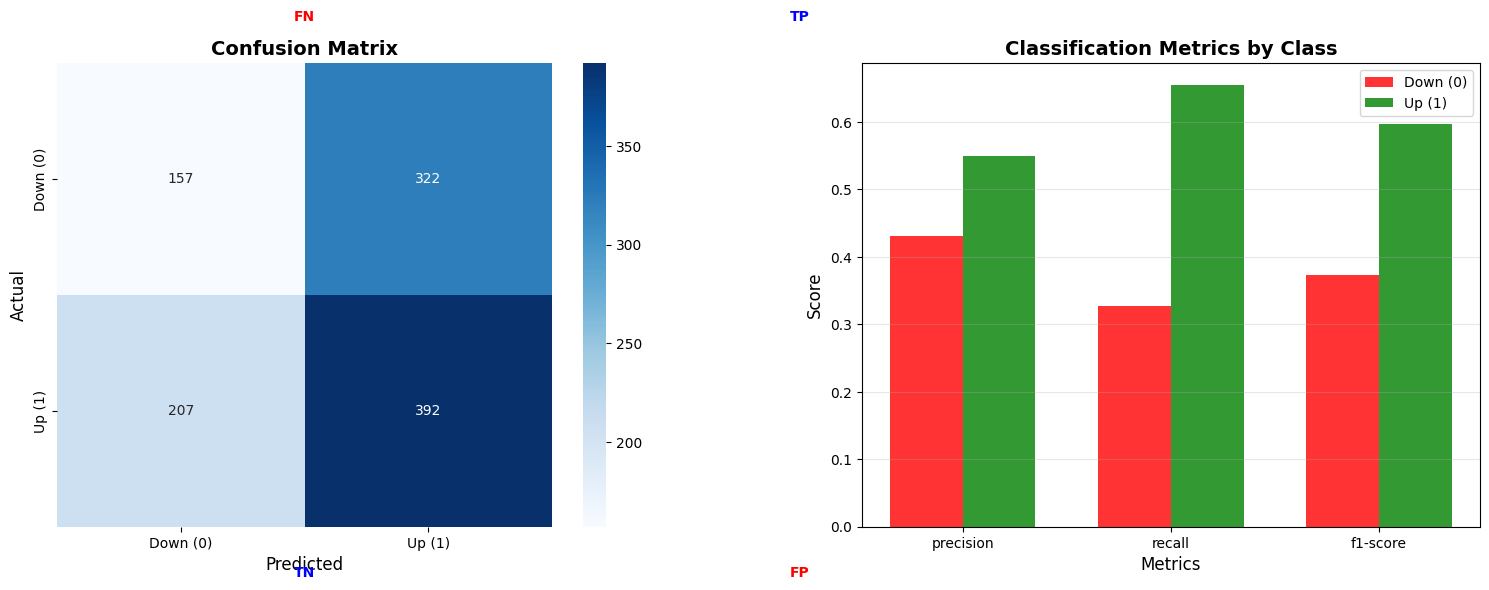

Confusion Matrix Components:
True Negatives (TN): 157
False Positives (FP): 322
False Negatives (FN): 207
True Positives (TP): 392

Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.43      0.33      0.37       479
      Up (1)       0.55      0.65      0.60       599

    accuracy                           0.51      1078
   macro avg       0.49      0.49      0.48      1078
weighted avg       0.50      0.51      0.50      1078



In [57]:
# 1. Generate Predictions
y_pred_final = trained_model.predict(X_test_scaled_final)

# 2. Create Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_final)

# 3. Plot Confusion Matrix + Metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'], ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# Label the quadrants (TN, FP, FN, TP)
ax1.text(0.5, -0.1, 'TN', ha='center', va='center', transform=ax1.transAxes,
         fontsize=10, color='blue', weight='bold')
ax1.text(1.5, -0.1, 'FP', ha='center', va='center', transform=ax1.transAxes,
         fontsize=10, color='red', weight='bold')
ax1.text(0.5, 1.1, 'FN', ha='center', va='center', transform=ax1.transAxes,
         fontsize=10, color='red', weight='bold')
ax1.text(1.5, 1.1, 'TP', ha='center', va='center', transform=ax1.transAxes,
         fontsize=10, color='blue', weight='bold')

# 4. Classification report
report = classification_report(y_test_final, y_pred_final, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Metrics visualization
metrics = ['precision', 'recall', 'f1-score']
class_0_scores = [report['0'][metric] for metric in metrics]
class_1_scores = [report['1'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

ax2.bar(x - width/2, class_0_scores, width, label='Down (0)', alpha=0.8, color='red')
ax2.bar(x + width/2, class_1_scores, width, label='Up (1)', alpha=0.8, color='green')

ax2.set_xlabel('Metrics', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Classification Metrics by Class', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Print detailed metrics
print("Confusion Matrix Components:")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

print(f"\nClassification Report:")
print(classification_report(y_test_final, y_pred_final, target_names=['Down (0)', 'Up (1)']))


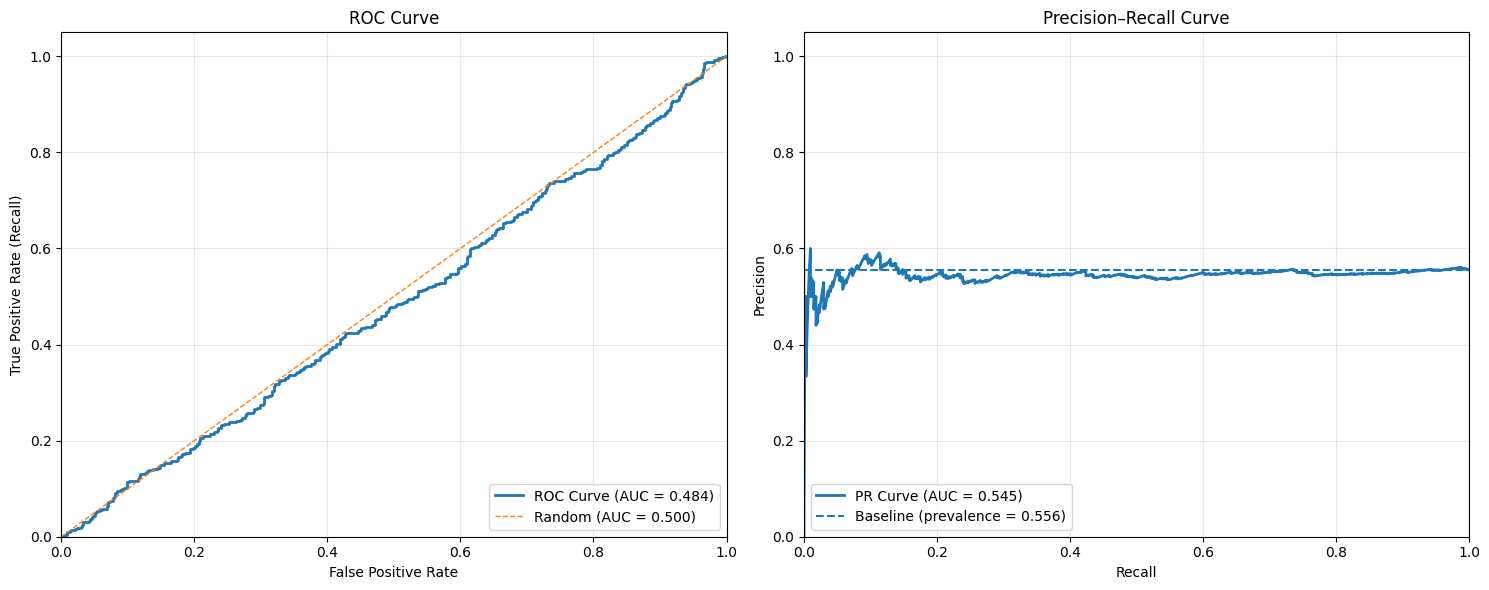

Model Performance Summary
- ROC AUC: 0.4839
- PR  AUC: 0.5446
- Accuracy @ 0.50 threshold: 0.5557
- AUC Interpretation: Very Poor classifier
  Accuracy @ threshold 0.30: 0.556
  Accuracy @ threshold 0.50: 0.556
  Accuracy @ threshold 0.70: 0.444


In [59]:
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    accuracy_score
)

# Predict probabilities for the positive class (UP = 1)
y_pred_proba = trained_model.predict_proba(X_test)[:, 1]
y_pred_label = (y_pred_proba >= 0.50).astype(int)  # default threshold for reference
accuracy = accuracy_score(y_test_final, y_pred_label)

# --- ROC: FPR vs TPR and AUC ---
fpr, tpr, roc_thresholds = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

# --- Precision–Recall curve and AUC (area under PR curve) ---
precision, recall, pr_thresholds = precision_recall_curve(y_test_final, y_pred_proba)

# Compute PR AUC using recall as x-axis (must pass in order: x=recall, y=precision)
pr_auc = auc(recall, precision)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], lw=1, linestyle='--', label='Random (AUC = 0.500)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Precision–Recall Curve
baseline = y_test_final.mean()  # prevalence (no-skill precision)
ax2.plot(recall, precision, lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
ax2.axhline(y=baseline, linestyle='--', label=f'Baseline (prevalence = {baseline:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision–Recall Curve')
ax2.legend(loc='lower left')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Summary printout ---
print("Model Performance Summary")
print(f"- ROC AUC: {roc_auc:.4f}")
print(f"- PR  AUC: {pr_auc:.4f}")
print(f"- Accuracy @ 0.50 threshold: {accuracy:.4f}")

# Simple interpretation of ROC AUC
if roc_auc >= 0.90:
    interp = "Excellent"
elif roc_auc >= 0.80:
    interp = "Good"
elif roc_auc >= 0.70:
    interp = "Fair"
elif roc_auc >= 0.60:
    interp = "Poor"
else:
    interp = "Very Poor"
print(f"- AUC Interpretation: {interp} classifier")

# (Optional) Show a few operating points around common thresholds
for thr in (0.30, 0.50, 0.70):
    preds = (y_pred_proba >= thr).astype(int)
    acc_thr = accuracy_score(y_test_final, preds)
    print(f"  Accuracy @ threshold {thr:.2f}: {acc_thr:.3f}")


In [60]:
from sklearn.inspection import permutation_importance
perm = permutation_importance(trained_model, X_test, y_test, n_repeats=100, random_state=None, n_jobs=-1)
perm

{'importances_mean': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'importances_std': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'importances': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

---

# EXERCISE - Feature Selection and Model Performance in Logistic Regression


### Question:

If I select the features better, would it improve the prediction accuracy of my logistic regression model?


### Your task (you must code it):

1. Try different feature subsets (drop, add, or transform features).
1. Train a logistic regression model for each subset (time-aware split OK).
1. Evaluate using ROC curve + AUC (and optionally Precision/Recall/F1).
1. Compare results and pick the best subset!


### Collective Exercise
* Copy & Paste your ROC and 'List of Features' that you came up with in the Collective Exercise document

https://docs.google.com/document/d/1-x_09xH9M7Hw1j3yGFaijt1181Ry8O6m3LZM4A1dao4/edit?usp=sharing

**REMEMBER THAT YOU NEED TO BE LOOGED IN WITH @FAU ACCOUNT**






In [15]:
##
## YOUR CODE GOES HERE
## MUST END WITH VISUALIZATION OF ROC CURVE

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

# SciPy provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations,
# differential equations, statistics and many other classes of problems.
# https://scipy.org/
#
from scipy import stats ### << key addition

print("All required libraries imported successfully!")

tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'META', 'AMZN', 'NVDA', 'JPM','IBM','MSFT']
stock_data = {}

print("Downloading stock data for classification analysis...")
for ticker in tickers:
    print(f"...loading {ticker}")
    stock_data[ticker] = yf.Ticker(ticker).history(
        start=datetime.now() - timedelta(days=365 * 2),  # 2 years of data
        end=datetime.now()
    )

print(f"\nSuccessfully loaded data for {len(stock_data)} stocks")
print(f"Date range: {stock_data['AAPL'].index[0].date()} to {stock_data['AAPL'].index[-1].date()}")
print(f"Total trading days: {len(stock_data['AAPL'])} per stock")


print("=" * 80)
print("FINANCIAL DATA OVERVIEW")
print("=" * 80)

# Let's examine one stock in detail to understand our raw data structure
sample_stock = 'AAPL'
sample_data = stock_data[sample_stock]

print(f"Sample Stock: {sample_stock}")
print(f"Date Range: {sample_data.index[0].date()} to {sample_data.index[-1].date()}")
print(f"Total Trading Days: {len(sample_data)}")

print(f"\nSample Data (First 5 Days for {sample_stock}):")
print(sample_data.head().round(2))

print(f"\nBasic Statistics for {sample_stock}:")
print(sample_data.describe().round(2))

print(f"\nData Quality Check:")
print(f"   • Missing Values: {sample_data.isnull().sum().sum()}")
print(f"   • Data Types: All numerical (float64)")
print(f"   • Index: DatetimeIndex (perfect for time series)")

# Show data for all stocks (summary)
print(f"\nAll Stocks Overview:")
print("=" * 50)
for ticker in tickers:
    data = stock_data[ticker]
    latest_price = data['Close'].iloc[-1]
    price_change = ((data['Close'].iloc[-1] / data['Close'].iloc[0]) - 1) * 100
    avg_volume = data['Volume'].mean()

    print(f"{ticker:6s}: Latest=${latest_price:7.2f} | Change={price_change:+6.1f}% | Avg Vol={avg_volume:,.0f}")

print("=" * 80)


def calculate_rsi_wilder(close: pd.Series, window: int = 14) -> pd.Series:
    """
    Wilder's RSI implementation (smoothed average gains/losses).
    We will shift(1) later so feature at date D uses info up to D-1.

    https://www.oanda.com/us-en/trade-tap-blog/trading-knowledge/understanding-the-relative-strength-index/
    """
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()
    rs = avg_gain / (avg_loss.replace(0, np.nan))
    rsi = 100 - (100 / (1 + rs))
    return rsi

def rolling_zscore(series: pd.Series, window: int = 20) -> pd.Series:
    """Rolling z-score over a trailing window."""
    roll_mean = series.rolling(window).mean()
    roll_std = series.rolling(window).std(ddof=0)
    return (series - roll_mean) / roll_std

def pct_change_safe(series: pd.Series, periods: int = 1) -> pd.Series:
    """Percent change with inf/NaN protection."""
    s = series.pct_change(periods)
    return s.replace([np.inf, -np.inf], np.nan)

# ---------- Core feature builder for ONE ticker (date-aware) ----------

def create_features_one_ticker(df: pd.DataFrame,
                               ticker_name: str,
                               rsi_window: int = 14,
                               fast_ma: int = 5,
                               slow_ma: int = 20,
                               vol_window: int = 20,
                               vol_ma_window: int = 5) -> pd.DataFrame:
    """
    Build predictive features that only use information available up to t-1.
    Returns a DataFrame indexed by date with feature columns + 'Ticker' + 'AsOfDate'.

    IMPORTANT:
    - The .shift(1) at the end means the row dated D represents features "as of" D,
      computed using data through D-1. We make that explicit via AsOfDate == index.
    """
    # Ensure datetime index is named & sorted for clarity
    df = df.copy()
    df = df.sort_index()
    df.index.name = 'Date'

    out = pd.DataFrame(index=df.index.copy())

    # Basic price & volume
    close = df['Close']
    volume = df['Volume']

    # 1) Returns & momentum (past info only)
    out['ret_1d']  = pct_change_safe(close, 1)
    out['ret_5d']  = pct_change_safe(close, 5)
    out['ret_10d'] = pct_change_safe(close, 10)

    # 2) Moving averages & spreads
    ma_fast = close.rolling(fast_ma).mean()
    ma_slow = close.rolling(slow_ma).mean()
    out['ma_fast'] = ma_fast
    out['ma_slow'] = ma_slow
    out['ma_spread'] = ma_fast - ma_slow
    out['price_minus_ma_fast'] = close - ma_fast
    out['price_minus_ma_slow'] = close - ma_slow

    # 3) Volatility (rolling std of daily returns)
    daily_ret = pct_change_safe(close, 1)
    out['volatility_20d'] = daily_ret.rolling(vol_window).std(ddof=0)
    out['volatility_200d'] = daily_ret.rolling(200).std(ddof=0)

    # 4) RSI (Wilder) and its z-score
    rsi = calculate_rsi_wilder(close, rsi_window)
    out['rsi'] = rsi
    out['rsi_z_20d'] = rolling_zscore(rsi, 20)

    # 5) Volume features
    vol_ma = volume.rolling(vol_ma_window).mean()
    out['vol_ma_5'] = vol_ma
    out['vol_rel'] = volume / vol_ma
    out['vol_above_ma'] = (volume > vol_ma).astype(int)

    # 6) Binary flags relative to MAs (price regime)
    out['price_above_ma_fast'] = (close > ma_fast).astype(int)
    out['price_above_ma_slow'] = (close > ma_slow).astype(int)

    # --- CRITICAL: Prevent look-ahead leakage ---
    # Shift ALL features by 1 so that the feature row at date D uses info up to D-1.
    out = out.shift(1)

    # Label when these features are *known*: AsOfDate == index (Date)
    out['AsOfDate'] = out.index

    # Keep identifier
    out['Ticker'] = ticker_name

    # Drop rows that are now NaN because of rolling/shift
    out = out.dropna()

    return out

# ---------- Build features for ALL tickers and combine ----------

def build_feature_matrix(stock_data: dict) -> pd.DataFrame:
    """
    stock_data: dict[ticker -> DataFrame with at least Close, Volume columns]
    Returns a combined feature matrix across all tickers (Date index).
    """
    frames = []
    for ticker, df in stock_data.items():
        if not {'Close', 'Volume'}.issubset(df.columns):
            print(f"Skipping {ticker}: required columns missing.")
            continue
        feats = create_features_one_ticker(df, ticker_name=ticker)
        frames.append(feats)

    if not frames:
        raise ValueError("No valid tickers to process.")
    X = pd.concat(frames, axis=0).sort_index()
    X.index.name = 'Date'
    return X

# ---------- (Optional) Friendly feature dictionary to print at the end ----------

FEATURE_DICTIONARY = {
    'ret_1d'               : '1-day % return of Close',
    'ret_5d'               : '5-day % return of Close',
    'ret_10d'              : '10-day % return of Close',
    'ma_fast'              : '5-day moving average of Close',
    'ma_slow'              : '20-day moving average of Close',
    'ma_spread'            : 'Difference: MA(5) - MA(20)',
    'price_minus_ma_fast'  : 'Close - MA(5)',
    'price_minus_ma_slow'  : 'Close - MA(20)',
    'volatility_20d'       : 'Rolling 20-day std of daily returns',
    'volatility_200d'      : 'Rolling 200-day std of daily returns',
    'rsi'                  : 'RSI(14) using Wilder’s smoothing',
    'rsi_z_20d'            : 'Z-score of RSI over trailing 20 days',
    'vol_ma_5'             : '5-day moving average of Volume',
    'vol_rel'              : 'Relative Volume = Volume / MA(5)',
    'vol_above_ma'         : '1 if Volume > MA(5) (yesterday), else 0',
    'price_above_ma_fast'  : '1 if Close > MA(5) (yesterday), else 0',
    'price_above_ma_slow'  : '1 if Close > MA(20) (yesterday), else 0',
    'AsOfDate'             : 'Date the features are considered known/usable',
    'Ticker'               : 'Security symbol'
}

def print_feature_dictionary(columns):
    print("\n=== Feature Dictionary (what each column means) ===")
    for c in columns:
        desc = FEATURE_DICTIONARY.get(c, "(no description available)")
        print(f"- {c}: {desc}")

# ---------- Build Feature Matrix ----------

X_features = build_feature_matrix(stock_data)

X_features

import pandas as pd
import numpy as np

def create_binary_target_one_ticker(df: pd.DataFrame, ticker_name: str) -> pd.DataFrame:
    """
    Create a binary target for one ticker:
      Target = 1 if next day's Close > today's Close, else 0.
    Drops the last row (no next-day price).
    Returns DataFrame indexed by Date with columns ['Target', 'Ticker'].
    """
    df = df.copy().sort_index()
    df.index.name = 'Date'

    next_close = df['Close'].shift(-1)
    target = (next_close > df['Close']).astype('Int64')  # Int64 tolerates NaN before drop

    out = pd.DataFrame(index=df.index.copy())
    out['Target'] = target
    out['Ticker'] = ticker_name

    # Remove last row where next day's price is missing
    out = out.dropna(subset=['Target'])
    # Cast to int now that NaNs are gone
    out['Target'] = out['Target'].astype(int)
    return out

def build_target_matrix(stock_data: dict) -> pd.DataFrame:
    """
    Build the binary target for all tickers in stock_data.
    Returns a Date-indexed DataFrame with ['Target', 'Ticker'].
    """
    frames = []
    for ticker, df in stock_data.items():
        if 'Close' not in df.columns:
            print(f"Skipping {ticker}: 'Close' column missing.")
            continue
        y = create_binary_target_one_ticker(df, ticker_name=ticker)
        frames.append(y)

    if not frames:
        raise ValueError("No valid tickers to process for targets.")
    y_all = pd.concat(frames, axis=0).sort_index()
    y_all.index.name = 'Date'
    return y_all

# --- Build y_target (make sure stock_data exists from your download step) ---
y_target = build_target_matrix(stock_data)

# --- Merge features (from Step A) with target (Step B) ---
# Assumes X_features already exists from Step A and includes ['Ticker', 'AsOfDate'] with Date index.
dataset = (X_features
           .reset_index()                  # bring Date out to merge
           .merge(y_target.reset_index(),  # merge on Date + Ticker
                  on=['Date', 'Ticker'],
                  how='inner')
           .set_index('Date')
           .sort_index())

# Optional: keep columns ordered nicely
cols_front = ['Ticker', 'AsOfDate', 'Target']
other_cols = [c for c in dataset.columns if c not in cols_front]
dataset = dataset[cols_front + other_cols]

print("Merged dataset shape (features + target):", dataset.shape)
print("\nSample rows (note: features are 'as of' Date; Target labels tomorrow's move):")
print(dataset.head(8)[['Ticker', 'AsOfDate', 'Target']])

# --- Quick sanity checks & class balance ---

# 1) No future leakage in merge (AsOfDate should equal the row Date)
same_dates = (dataset.index.normalize() == pd.to_datetime(dataset['AsOfDate']).dt.normalize())
if not bool(same_dates.all()):
    raise AssertionError("AsOfDate does not match Date for some rows. Check shifting/merge steps.")

# 2) Class balance overall
print("\nTarget distribution (overall):")
print(dataset['Target'].value_counts(normalize=True).rename({0: 'Down/NotUp', 1: 'Up'}).round(3))

# 3) Class balance by ticker (handy for students)
print("\nTarget distribution by Ticker (first few):")
by_ticker = (dataset
             .groupby('Ticker')['Target']
             .value_counts(normalize=True)
             .rename('ratio')
             .reset_index()
             .pivot(index='Ticker', columns='Target', values='ratio')
             .rename(columns={0: 'Down/NotUp', 1: 'Up'})
             .round(3))
print(by_ticker.head())

# 4) Show a tiny timeline snippet for one ticker to reinforce timing
one = dataset[dataset['Ticker'] == 'AAPL'].head(6)
print("\nAAPL timeline peek (Date, AsOfDate, Target):")
print(one[['Ticker', 'AsOfDate', 'Target']])

dataset = (
    X_features
    .reset_index()                  # bring 'Date' out of index
    .merge(y_target.reset_index(),  # align by Date + Ticker
           on=['Date', 'Ticker'],
           how='inner')
    .set_index('Date')
    .sort_index()
)

dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -----------------------------
# 1  Select Features and Target
# -----------------------------
# Choose which feature columns will be used to train the model (X)
# and specify which column represents the target variable (y).
#

feature_cols = [
    'ret_1d',
    'ret_5d',
    #'ret_10d',
    'ma_fast',
    #'ma_slow',
    'ma_spread',
    #'price_minus_ma_fast',
    #'price_minus_ma_slow',
    'rsi',
    'rsi_z_20d',
    'volatility_20d',
    'volatility_200d',
    #'vol_rel',
    'price_above_ma_fast',
    #'price_above_ma_slow'
]

X = dataset[feature_cols]   # Feature matrix (inputs)
y = dataset['Target']       # Binary target (0 = Not Up, 1 = Up)

# -----------------------------
# 2  Split into Train/Test Sets
# -----------------------------
# Divide the dataset into training (75%) and testing (25%) subsets.
# Training data is used to learn the model; testing data evaluates it later.
#

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# -----------------------------
# 3  Scale Features
# -----------------------------
# Standardize features so they are on the same scale.
# This ensures that variables with larger ranges do not dominate the model.
#

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4  Train Logistic Regression
# -----------------------------
# Fit the logistic regression model on the scaled training data.
# The model learns coefficients (β values) that best separate class 0 vs 1.
#

model = LogisticRegression(max_iter=1000, solver='lbfgs')
model.fit(X_train_scaled, y_train)

print("Logistic Regression model successfully trained.")

# -----------------------------
# 5  Save Model Objects for Step D (Evaluation)
# -----------------------------
# Keep the trained model and prepared test data for the evaluation phase.
# These will be used to measure accuracy, precision, recall, and AUC later.
trained_model = model
X_test_scaled_final = X_test_scaled
y_test_final = y_test
print("Model and scaled test data are ready for evaluation in Step D.")



All required libraries imported successfully!
...loading AAPL
...loading GOOGL
...loading MSFT
...loading TSLA
...loading META
...loading AMZN
...loading NVDA
...loading JPM
...loading IBM
...loading MSFT

Successfully loaded data for 9 stocks
Date range: 2023-10-23 to 2025-10-21
Total trading days: 501 per stock
FINANCIAL DATA OVERVIEW
Sample Stock: AAPL
Date Range: 2023-10-23 to 2025-10-21
Total Trading Days: 501

Sample Data (First 5 Days for AAPL):
                             Open    High     Low   Close    Volume  \
Date                                                                  
2023-10-23 00:00:00-04:00  169.25  172.32  168.28  171.32  55980100   
2023-10-24 00:00:00-04:00  171.37  171.99  169.79  171.76  43816600   
2023-10-25 00:00:00-04:00  170.21  171.38  168.99  169.44  57157000   
2023-10-26 00:00:00-04:00  168.72  169.72  164.06  165.27  70625300   
2023-10-27 00:00:00-04:00  165.29  167.32  165.21  166.59  58499100   

                           Dividends  Stock S

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -----------------------------
# 1  Select Features and Target
# -----------------------------
# Choose which feature columns will be used to train the model (X)
# and specify which column represents the target variable (y).
#

feature_cols_ALL = [
    'ret_1d',
    'ret_5d',
    'ret_10d',
    'ma_fast',
    'ma_slow',
    'ma_spread',
    'price_minus_ma_fast',
    'price_minus_ma_slow',
    'rsi',
    'rsi_z_20d',
    'volatility_20d',
    'volatility_200d',
    'vol_rel',
    'price_above_ma_fast',
    'price_above_ma_slow'
]

X_ALL = dataset[feature_cols_ALL]   # Feature matrix (inputs)
y_ALL = dataset['Target']       # Binary target (0 = Not Up, 1 = Up)

# -----------------------------
# 2  Split into Train/Test Sets
# -----------------------------
# Divide the dataset into training (75%) and testing (25%) subsets.
# Training data is used to learn the model; testing data evaluates it later.
#

X_train_All, X_test_All, y_train_All, y_test_All = train_test_split(
    X_ALL, y_ALL, test_size=0.25, random_state=42, stratify=y_ALL
)
print(f"Train shape: {X_train_All.shape}, Test shape: {X_test_All.shape}")

# -----------------------------
# 3  Scale Features
# -----------------------------
# Standardize features so they are on the same scale.
# This ensures that variables with larger ranges do not dominate the model.
#

scaler_All = StandardScaler()
X_train_scaled_All = scaler_All.fit_transform(X_train_All)
X_test_scaled_All = scaler_All.transform(X_test_All)

# -----------------------------
# 4  Train Logistic Regression
# -----------------------------
# Fit the logistic regression model on the scaled training data.
# The model learns coefficients (β values) that best separate class 0 vs 1.
#

model_All = LogisticRegression(max_iter=1000, solver='lbfgs')
model_All.fit(X_train_scaled_All, y_train_All)

print("Logistic Regression model successfully trained.")

# -----------------------------
# 5  Save Model Objects for Step D (Evaluation)
# -----------------------------
# Keep the trained model and prepared test data for the evaluation phase.
# These will be used to measure accuracy, precision, recall, and AUC later.
trained_model_ALL_Features = model_All
X_test_scaled_final_ALL_Features = X_test_scaled_All
y_test_final = y_test_All # Keep y_test_final consistent
print("Model and scaled test data are ready for evaluation in Step D.")

Train shape: (2025, 15), Test shape: (675, 15)
Logistic Regression model successfully trained.
Model and scaled test data are ready for evaluation in Step D.


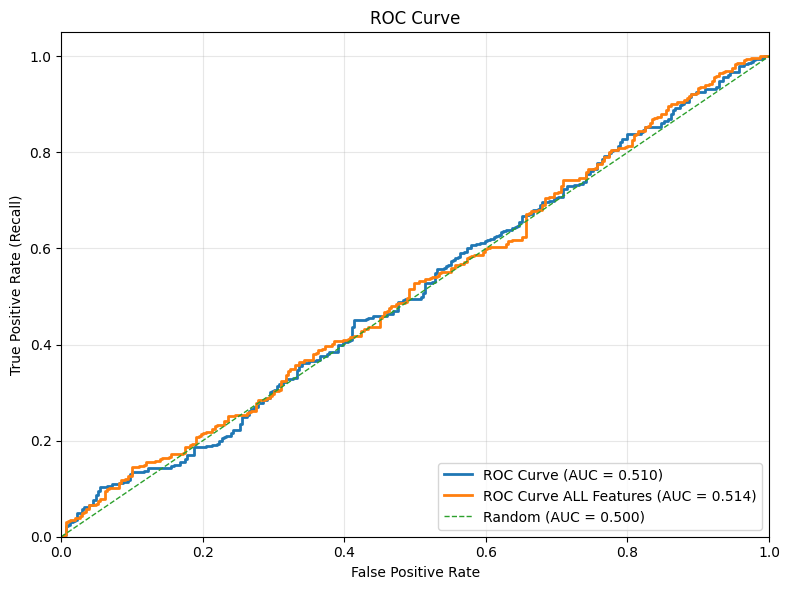

Model Performance Summary
- ROC AUC: 0.5103
- PR  AUC: 0.5583
- Accuracy @ 0.50 threshold: 0.5378
- AUC Interpretation: Very Poor classifier
  Accuracy @ threshold 0.30: 0.542
  Accuracy @ threshold 0.50: 0.538
  Accuracy @ threshold 0.70: 0.458


In [18]:
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    accuracy_score
)

# Predict probabilities for the positive class (UP = 1)
y_pred_proba = trained_model.predict_proba(X_test_scaled_final)[:, 1]
y_pred_proba_All = trained_model_ALL_Features.predict_proba(X_test_scaled_final_ALL_Features)[:, 1]
y_pred_label = (y_pred_proba >= 0.50).astype(int)  # default threshold for reference
accuracy = accuracy_score(y_test_final, y_pred_label)

# --- ROC: FPR vs TPR and AUC ---
fpr, tpr, roc_thresholds = roc_curve(y_test_final, y_pred_proba)
roc_auc = auc(fpr, tpr)

fpr_All, tpr_All, roc_thresholds_All = roc_curve(y_test_final, y_pred_proba_All)
roc_auc_All = auc(fpr_All, tpr_All)


# --- Precision–Recall curve and AUC (area under PR curve) ---
precision, recall, pr_thresholds = precision_recall_curve(y_test_final, y_pred_proba)

# Compute PR AUC using recall as x-axis (must pass in order: x=recall, y=precision)
pr_auc = auc(recall, precision)

# --- Plotting ---
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6)) # Modified to have only one subplot

# ROC Curve
ax1.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')

ax1.plot(fpr_All, tpr_All, lw=2, label=f'ROC Curve ALL Features (AUC = {roc_auc_All:.3f})')
ax1.plot([0, 1], [0, 1], lw=1, linestyle='--', label='Random (AUC = 0.500)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# Precision–Recall Curve (Removed)
#baseline = y_test_final.mean()  # prevalence (no-skill precision)
#ax2.plot(recall, precision, lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
#ax2.axhline(y=baseline, linestyle='--', label=f'Baseline (prevalence = {baseline:.3f})')
#ax2.set_xlim([0.0, 1.0])
#ax2.set_ylim([0.0, 1.05])
#ax2.set_xlabel('Recall')
#ax2.set_ylabel('Precision')
#ax2.set_title('Precision–Recall Curve')
#ax2.legend(loc='lower left')
#ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Summary printout ---
print("Model Performance Summary")
print(f"- ROC AUC: {roc_auc:.4f}")
print(f"- PR  AUC: {pr_auc:.4f}")
print(f"- Accuracy @ 0.50 threshold: {accuracy:.4f}")

# Simple interpretation of ROC AUC
if roc_auc >= 0.90:
    interp = "Excellent"
elif roc_auc >= 0.80:
    interp = "Good"
elif roc_auc >= 0.70:
    interp = "Fair"
elif roc_auc >= 0.60:
    interp = "Poor"
else:
    interp = "Very Poor"
print(f"- AUC Interpretation: {interp} classifier")

# (Optional) Show a few operating points around common thresholds
for thr in (0.30, 0.50, 0.70):
    preds = (y_pred_proba >= thr).astype(int)
    acc_thr = accuracy_score(y_test_final, preds)
    print(f"  Accuracy @ threshold {thr:.2f}: {acc_thr:.3f}")